In [3]:
# Удобные массивы
import numpy as np

# Преобразование фурье
import scipy.fft as fft
import scipy.fftpack as fftp

# Math
import math

# Image operations
import cv2

# Собственные модули
import lib.utils.utils as Utils
import lib.utils.plotting as Plotting

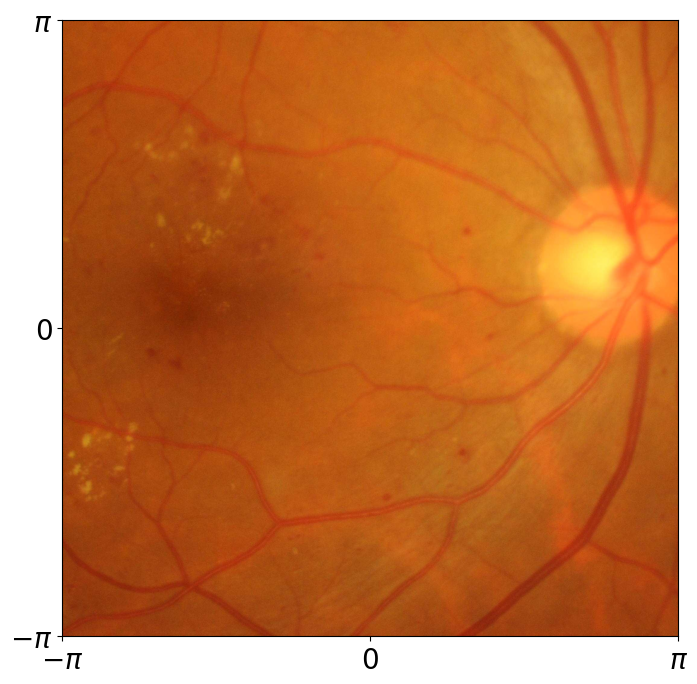

In [2]:
image_original = Utils.image_load('Samples/Samples 3/7.bmp', mode='rgb')
Plotting.plot_image(image_original)

In [3]:
import struct

def load_otf(filepath):
    # Read byte stream
    with open(filepath, mode="rb") as f:
        # Lambda and radius in meters
        lambda_and_radius = f.read(16)
        lambda_, radius = struct.unpack('<d', lambda_and_radius[0:8])[0], struct.unpack('<d', lambda_and_radius[8:16])[0]
        print('Lambda, Radius:', lambda_, radius)
        
        # Beam center shift in meters (0, 0 is default)
        centerX_and_centerY = f.read(16)
        centerX, centerY = struct.unpack('<d', centerX_and_centerY[0:8])[0], struct.unpack('<d', centerX_and_centerY[8:16])[0]
        print('CenterX, CenterY:', centerX, centerY)
        
        # Factor: Radius * Factor = physical image size
        factor = struct.unpack('<d', f.read(8))[0]
        print('Factor:', factor)
        
        # CT byte
        image_type =int.from_bytes(f.read(1), 'big')
        print('CT', image_type)
        if image_type != 0 and image_type != 1:
            raise Exception('Corrupted CT byte')
        
        # Image sizes
        sizeX, sizeY, sizeZ = struct.unpack('<i', f.read(4))[0], struct.unpack('<i', f.read(4))[0], struct.unpack('<i', f.read(4))[0]
        print('Sizes:', sizeX, sizeY, sizeZ)
        shape = (sizeY, sizeX)
        
        # Frame inside image
        fx0 = f.read(4)
        fdx = f.read(4)
        fy0 = f.read(4)
        fdy = f.read(4)
        fz0 = f.read(4)
        fdx = f.read(4)
        
        # Construct real/imag parts
        real_part = np.empty(shape)
        imag_part = np.empty(shape)
        
        # Read bytes
        for i in range(shape[0]):
            for j in range(shape[1]):
                complex = f.read(16)
                real_part[i, j] = struct.unpack('<d', complex[0:8])[0]
                imag_part[i, j] = struct.unpack('<d', complex[8:16])[0]
        
        # Return result (depending on CT)
        if image_type == 0:
            return real_part + 1j * imag_part
        elif image_type == 1:
            return real_part * np.exp(1j * imag_part)

Lambda, Radius: 5e-07 0.014
CenterX, CenterY: 0.0 0.0
Factor: 4.0
CT 0
Sizes: 2048 2048 1
Lambda, Radius: 5e-07 0.014
CenterX, CenterY: 0.0 0.0
Factor: 4.0
CT 0
Sizes: 2048 2048 1
Lambda, Radius: 5e-07 0.014
CenterX, CenterY: 0.0 0.0
Factor: 4.0
CT 0
Sizes: 2048 2048 1


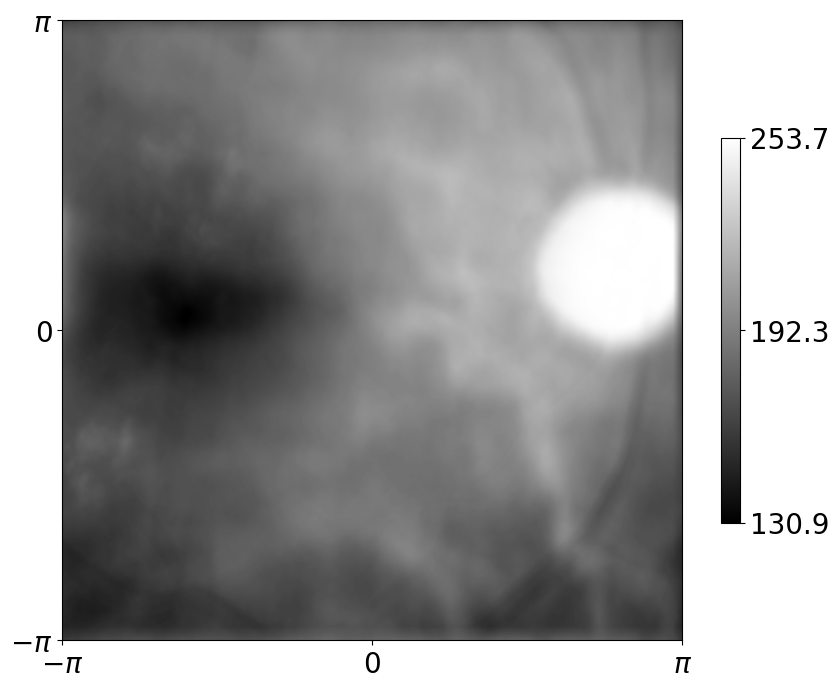

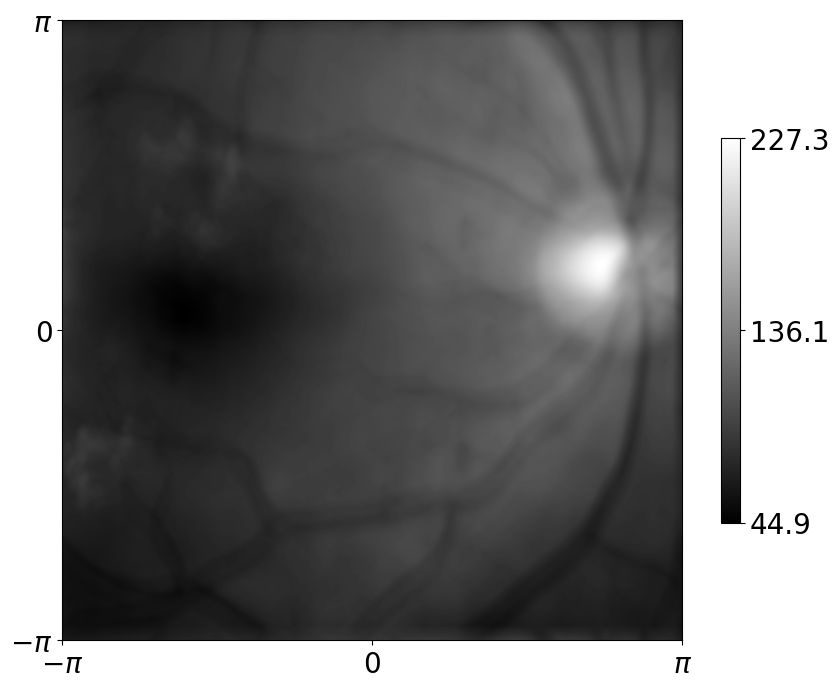

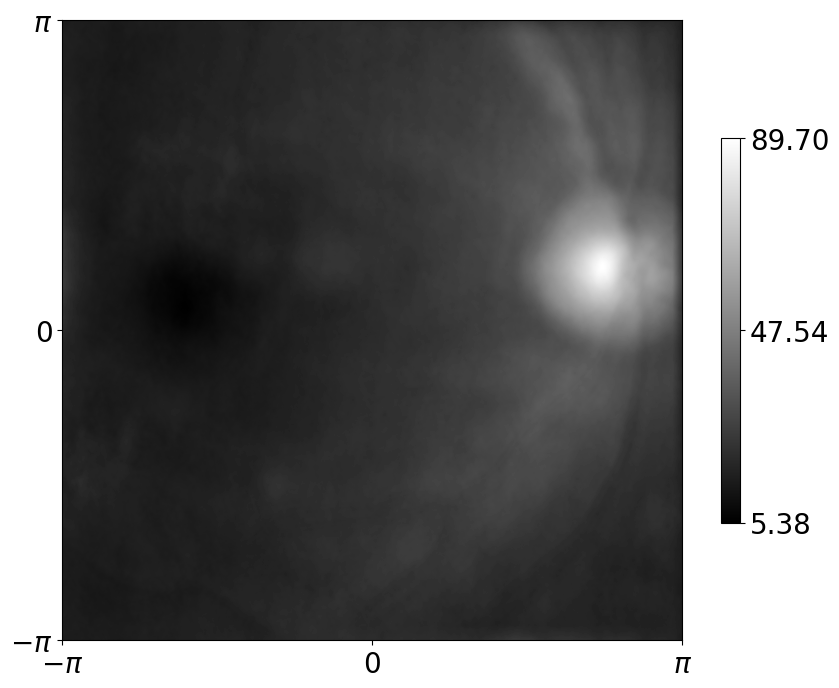

In [4]:
r = load_otf('Samples/Samples 3/con_r1.cxd').real
g = load_otf('Samples/Samples 3/con_g1.cxd').real
b = load_otf('Samples/Samples 3/con_b1.cxd').real

Plotting.plot_image(r)
Plotting.plot_image(g)
Plotting.plot_image(b)

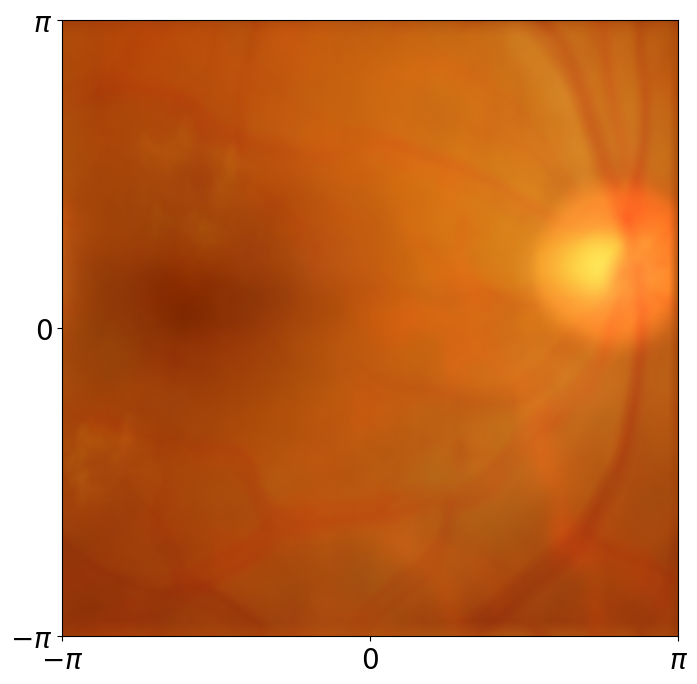

In [5]:
image_blurred = Utils.image_normalize(np.dstack((r,g,b)))
Plotting.plot_image(image_blurred)

Lambda, Radius: 5.8e-07 0.014
CenterX, CenterY: 0.0 0.0
Factor: 4.0
CT 0
Sizes: 2048 2048 1
Lambda, Radius: 5.5e-07 0.014
CenterX, CenterY: 0.0 0.0
Factor: 4.0
CT 0
Sizes: 2048 2048 1
Lambda, Radius: 4.5e-07 0.014
CenterX, CenterY: 0.0 0.0
Factor: 4.0
CT 0
Sizes: 2048 2048 1


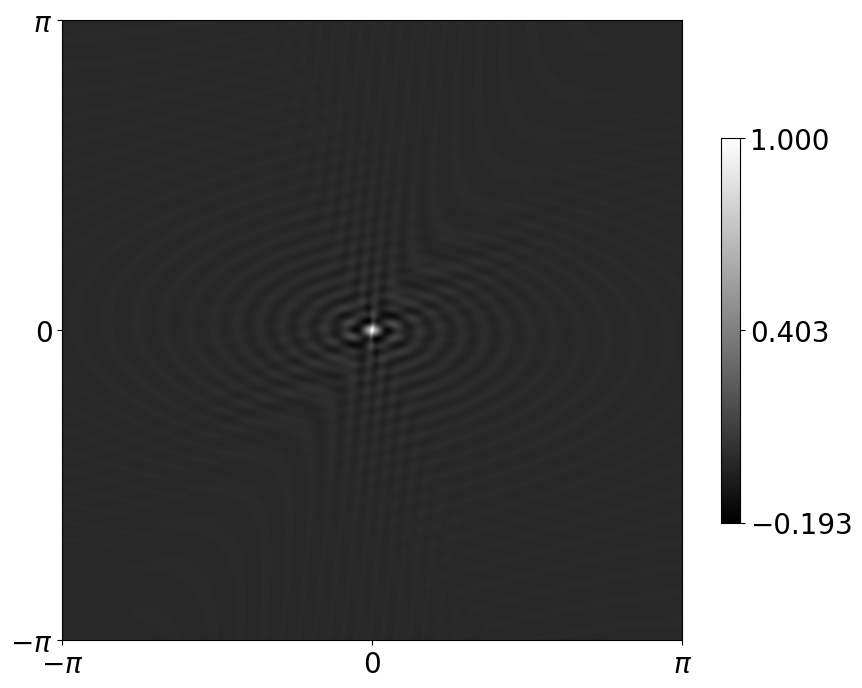

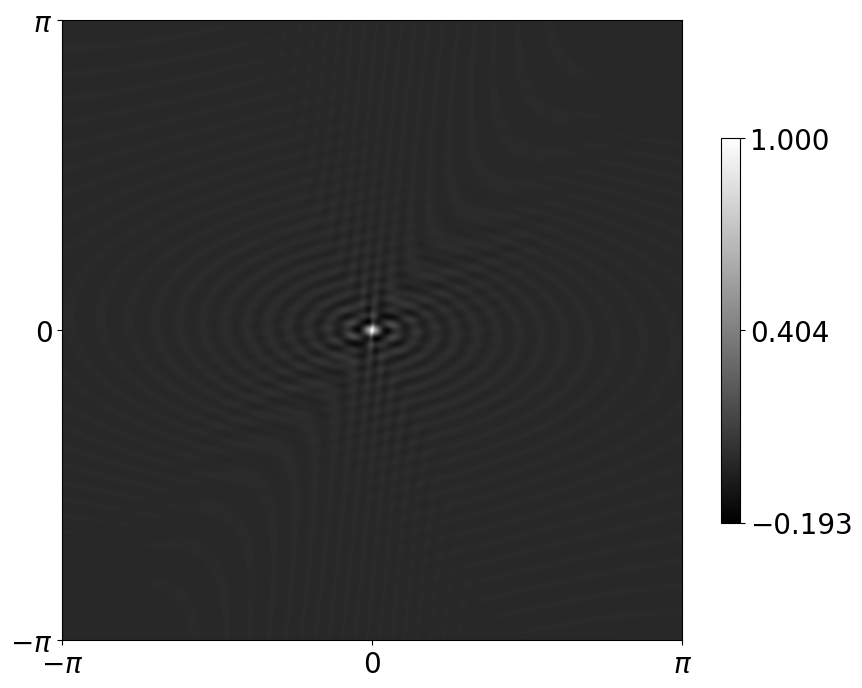

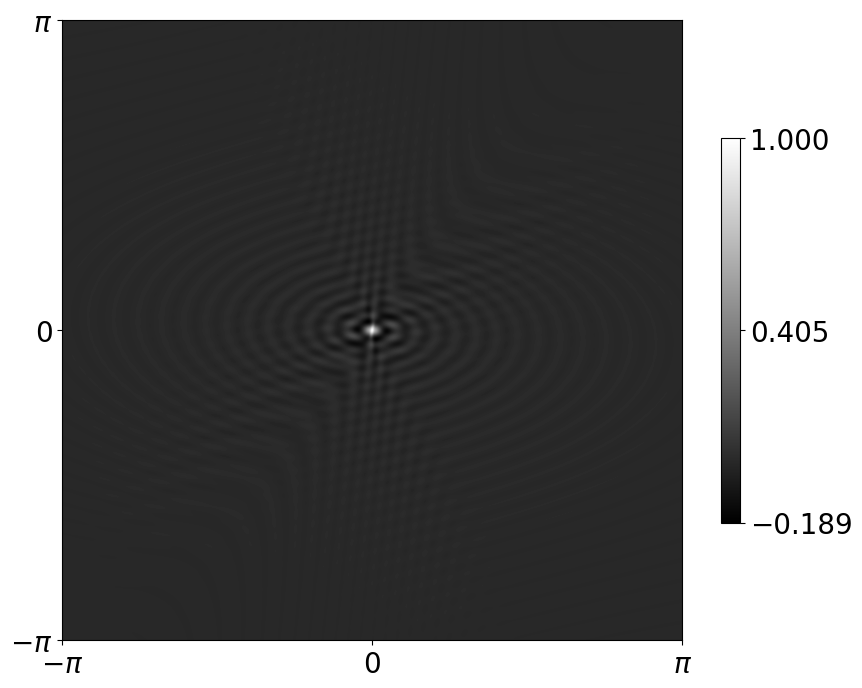

In [6]:
otf1 = fftp.fftshift(load_otf('Samples/Samples 3/otf_r1.cxd'))
otf2 = fftp.fftshift(load_otf('Samples/Samples 3/otf_g1.cxd'))
otf3 = fftp.fftshift(load_otf('Samples/Samples 3/otf_b1.cxd'))

Plotting.plot_image(fftp.fftshift(otf1.real))
Plotting.plot_image(fftp.fftshift(otf2.real))
Plotting.plot_image(fftp.fftshift(otf3.real))

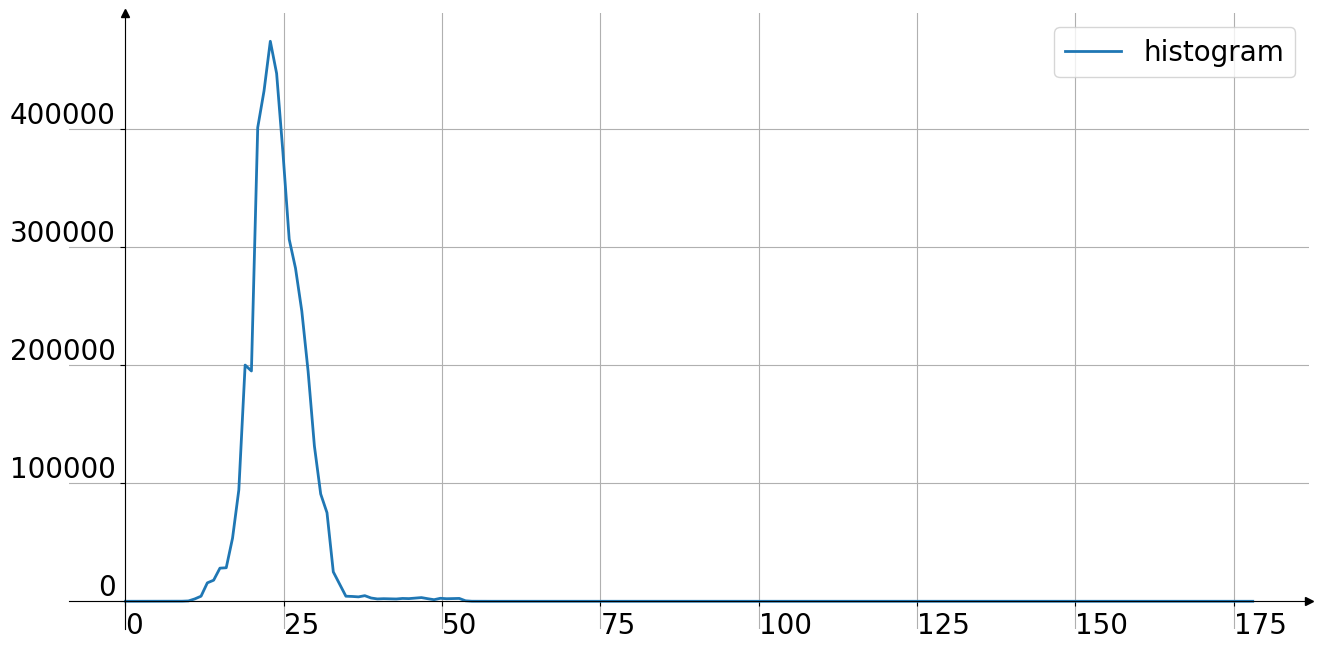

In [8]:
histogram_original, bin_edges_original = np.histogram(cv2.cvtColor(np.float32(image_original), cv2.COLOR_RGB2HSV)[:, :, 0], bins=180, range=(0, 179))
Plotting.plot_functions([Plotting.FuncDesc(bin_edges_original[0:-1], histogram_original, 'histogram')])

(512, 512, 3)


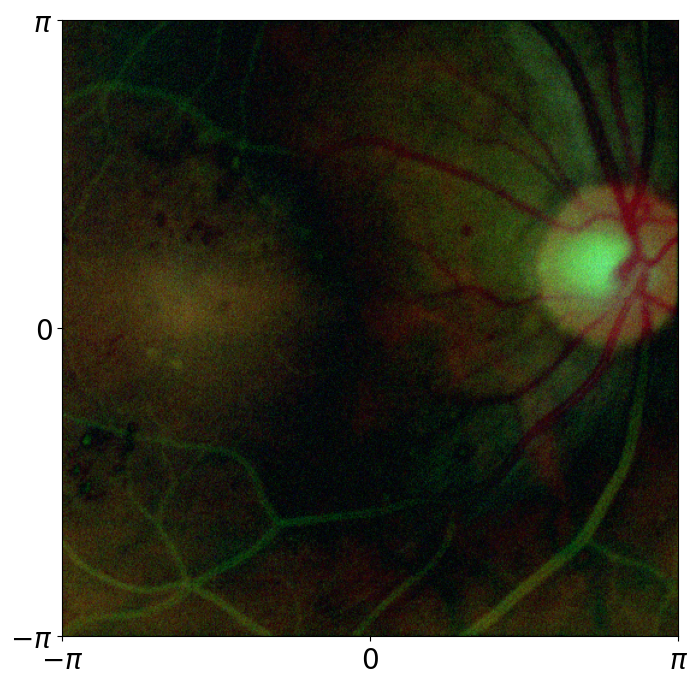

In [9]:
image_rest = Utils.image_load('Samples/Samples 3/72-a-0001.bmp', mode='rgb')
print(image_rest.shape)
Plotting.plot_image(image_rest)

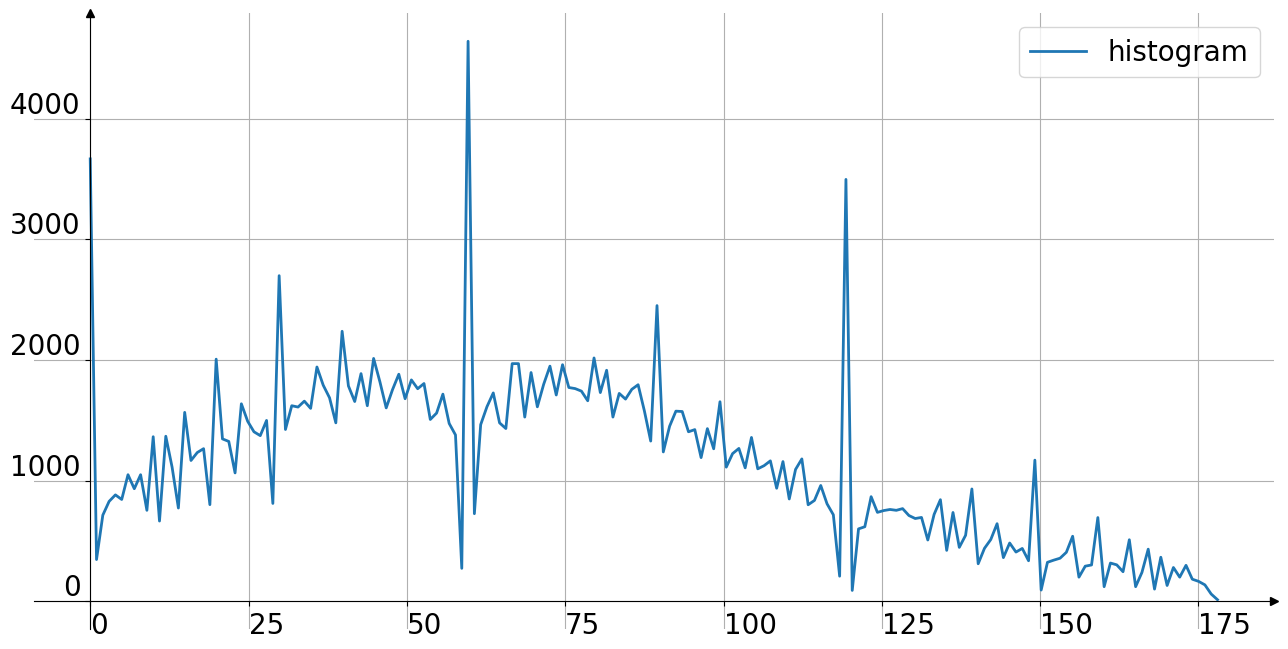

In [10]:
histogram_rest, bin_edges_rest = np.histogram(cv2.cvtColor(np.float32(image_rest), cv2.COLOR_RGB2HSV)[:, :, 0], bins=180, range=(0, 179))
Plotting.plot_functions([Plotting.FuncDesc(bin_edges_rest[0:-1], histogram_rest, 'histogram')])

In [11]:
def exp_val(histogram, bins, image_shape):
    return np.sum(bins[0:-1] * histogram / (image_shape[0]*image_shape[1]))

def disp(histogram, bins, image_shape):
    return exp_val(histogram, (bins - exp_val(histogram, bins, image_shape))**2, image_shape)

def std_dev(histogram, bins, image_shape):
    return math.sqrt(disp(histogram, bins, image_shape))

def assim(histogram, bins, image_shape):
    return exp_val(histogram, (bins - exp_val(histogram, bins, image_shape))**3, image_shape) / std_dev(histogram, bins, image_shape)**3

In [12]:
print('Мат ожидание исходного -', exp_val(histogram_original, bin_edges_original, image_original.shape))
print('Мат ожидание плохо восстановленного -', exp_val(histogram_rest, bin_edges_rest, image_rest.shape))
print('Дисперсия исходного -', disp(histogram_original, bin_edges_original, image_original.shape))
print('Дисперсия плохо восстановленного -', disp(histogram_rest, bin_edges_rest, image_rest.shape))
print('Стандартное отклонение исходного -', std_dev(histogram_original, bin_edges_original, image_original.shape))
print('Стандартное отклонение плохо восстановленного -', std_dev(histogram_rest, bin_edges_rest, image_rest.shape))
print('Асимметрия исходного -', assim(histogram_original, bin_edges_original, image_original.shape))
print('Асимметрия плохо восстановленного -', assim(histogram_rest, bin_edges_rest, image_rest.shape))

Мат ожидание исходного - 24.102929919418102
Мат ожидание плохо восстановленного - 55.07099910876559
Дисперсия исходного - 18.69225297126587
Дисперсия плохо восстановленного - 1503.7020044330238
Стандартное отклонение исходного - 4.323453824347598
Стандартное отклонение плохо восстановленного - 38.77759668201504
Асимметрия исходного - 1.1639071314072462
Асимметрия плохо восстановленного - 1.4105190549288145
